In [1]:
"""
SEO Content Quality & Duplicate Detector Pipeline
==================================================
Author: Data Science Placement Candidate
Date: November 2025

This notebook implements a complete ML pipeline for SEO content analysis including:
- HTML parsing and text extraction
- NLP feature engineering
- Duplicate detection using cosine similarity
- Quality scoring using supervised ML
- Real-time URL analysis function

Requirements: See requirements.txt
"""

'\nSEO Content Quality & Duplicate Detector Pipeline\n==================================================\nAuthor: Data Science Placement Candidate\nDate: November 2025\n\nThis notebook implements a complete ML pipeline for SEO content analysis including:\n- HTML parsing and text extraction\n- NLP feature engineering\n- Duplicate detection using cosine similarity\n- Quality scoring using supervised ML\n- Real-time URL analysis function\n\nRequirements: See requirements.txt\n'

In [3]:
# ============================================================================
# SECTION 1: ENVIRONMENT SETUP & IMPORTS
# ============================================================================

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# HTML Parsing
from bs4 import BeautifulSoup
import re

# NLP & Text Processing
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import textstat

# Feature Engineering
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    confusion_matrix, 
    f1_score
)

# Similarity & Clustering
from sklearn.metrics.pairwise import cosine_similarity

# Web Scraping (for real-time function)
import requests
from time import sleep

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
import json
import os
from pathlib import Path
from typing import Dict, List, Tuple

# Download required NLTK data
print("Downloading required NLTK data...")
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
print("Setup complete!\n")

Setup complete!



In [9]:
# ============================================================================
# SECTION 2: PROJECT CONFIGURATION
# ============================================================================
class Config:
    """Central configuration for the SEO pipeline"""
    
    # Get the project root directory (parent of notebooks folder)
    PROJECT_ROOT = Path(__file__).resolve().parent.parent if '__file__' in globals() else Path.cwd().parent
    
    # If running from notebook in notebooks folder, go up one level
    # If running from project root, use current directory
    if (Path.cwd() / "notebooks").exists() and (Path.cwd() / "data").exists():
        # Already at project root
        PROJECT_ROOT = Path.cwd()
    elif Path.cwd().name == "notebooks":
        # Inside notebooks folder, go up one level
        PROJECT_ROOT = Path.cwd().parent
    else:
        # Default to current directory
        PROJECT_ROOT = Path.cwd()
    
    # Paths - use existing directories
    DATA_DIR = PROJECT_ROOT / "data"
    MODELS_DIR = PROJECT_ROOT / "models"
    
    # File paths
    INPUT_CSV = DATA_DIR / "data.csv"
    EXTRACTED_CSV = DATA_DIR / "extracted_content.csv"
    FEATURES_CSV = DATA_DIR / "features.csv"
    DUPLICATES_CSV = DATA_DIR / "duplicates.csv"
    
    # Thresholds
    THIN_CONTENT_THRESHOLD = 500  # words
    DUPLICATE_SIMILARITY_THRESHOLD = 0.80
    
    # Quality labeling criteria
    HIGH_QUALITY_MIN_WORDS = 1500
    HIGH_QUALITY_MIN_READABILITY = 50
    HIGH_QUALITY_MAX_READABILITY = 70
    LOW_QUALITY_MAX_WORDS = 500
    LOW_QUALITY_MAX_READABILITY = 30
    
    # Model settings
    RANDOM_STATE = 42
    TEST_SIZE = 0.3
    
    # Web scraping settings
    REQUEST_DELAY = 1.5  # seconds
    REQUEST_TIMEOUT = 10  # seconds
    USER_AGENT = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36"

# Verify directories exist (don't create new ones)
if not Config.DATA_DIR.exists():
    raise FileNotFoundError(f"Data directory not found: {Config.DATA_DIR}")
if not Config.MODELS_DIR.exists():
    raise FileNotFoundError(f"Models directory not found: {Config.MODELS_DIR}")

print("✓ Configuration loaded")
print(f"✓ Project root: {Config.PROJECT_ROOT}")
print(f"✓ Data directory: {Config.DATA_DIR}")
print(f"✓ Models directory: {Config.MODELS_DIR}")

# Verify data.csv exists
if Config.INPUT_CSV.exists():
    print(f"✓ Input file found: {Config.INPUT_CSV}\n")
else:
    print(f"⚠ Input file not found: {Config.INPUT_CSV}")
    print(f"  Please ensure data.csv is in the data folder\n")

✓ Configuration loaded
✓ Project root: /Users/kiranguruv/seo-content-detector
✓ Data directory: /Users/kiranguruv/seo-content-detector/data
✓ Models directory: /Users/kiranguruv/seo-content-detector/models
✓ Input file found: /Users/kiranguruv/seo-content-detector/data/data.csv



In [10]:
# ============================================================================
# PHASE 1: HTML PARSING & TEXT EXTRACTION (15%)
# ============================================================================

def parse_html_content(html: str) -> Dict[str, str]:
    """
    Parse HTML content and extract structured information.
    
    Args:
        html: Raw HTML string
        
    Returns:
        Dictionary with 'title' and 'body_text' keys
        
    Error Handling:
        - Returns None values if parsing fails
        - Uses try-except to handle malformed HTML
    """
    try:
        soup = BeautifulSoup(html, 'html.parser')
        
        # Extract title
        title_tag = soup.find('title')
        title = title_tag.get_text().strip() if title_tag else ""
        
        # Remove script and style elements
        for script in soup(['script', 'style', 'nav', 'footer', 'aside']):
            script.decompose()
        
        # Extract main content - prioritize semantic HTML tags
        main_content = None
        for tag in ['article', 'main', 'div[role="main"]']:
            main_content = soup.find(tag.split('[')[0])
            if main_content:
                break
        
        # Fallback to all paragraphs if no main content found
        if not main_content:
            main_content = soup
        
        # Get text from paragraphs
        paragraphs = main_content.find_all('p')
        body_text = ' '.join([p.get_text().strip() for p in paragraphs])
        
        # Clean up whitespace
        body_text = re.sub(r'\s+', ' ', body_text).strip()
        
        return {
            'title': title,
            'body_text': body_text
        }
        
    except Exception as e:
        print(f"Error parsing HTML: {str(e)[:100]}")
        return {
            'title': None,
            'body_text': None
        }


def extract_content_from_dataset(df: pd.DataFrame) -> pd.DataFrame:
    """
    Process entire dataset and extract structured content.
    
    Args:
        df: DataFrame with 'url' and 'html_content' columns
        
    Returns:
        DataFrame with extracted features
        
    Output Schema:
        - url: Original URL
        - title: Page title
        - body_text: Clean extracted text
        - word_count: Number of words in body text
    """
    print("=" * 70)
    print("PHASE 1: HTML PARSING & TEXT EXTRACTION")
    print("=" * 70)
    
    results = []
    total_rows = len(df)
    failed_count = 0
    
    for idx, row in df.iterrows():
        try:
            url = row['url']
            html = row.get('html_content', '')
            
            # Parse HTML
            parsed = parse_html_content(html)
            
            # Calculate word count
            word_count = len(parsed['body_text'].split()) if parsed['body_text'] else 0
            
            results.append({
                'url': url,
                'title': parsed['title'],
                'body_text': parsed['body_text'],
                'word_count': word_count
            })
            
            # Progress indicator
            if (idx + 1) % 10 == 0:
                print(f"Processed: {idx + 1}/{total_rows} URLs")
                
        except Exception as e:
            failed_count += 1
            print(f"Failed to process row {idx}: {str(e)[:50]}")
            results.append({
                'url': row.get('url', 'unknown'),
                'title': None,
                'body_text': None,
                'word_count': 0
            })
    
    extracted_df = pd.DataFrame(results)
    
    # Summary statistics
    print(f"\n✓ Extraction complete!")
    print(f"  Total URLs processed: {total_rows}")
    print(f"  Successfully extracted: {total_rows - failed_count}")
    print(f"  Failed extractions: {failed_count}")
    print(f"  Average word count: {extracted_df['word_count'].mean():.0f}")
    print(f"  Min word count: {extracted_df['word_count'].min()}")
    print(f"  Max word count: {extracted_df['word_count'].max()}\n")
    
    return extracted_df

In [11]:
# Verify data.csv exists before processing
import os

if not Config.INPUT_CSV.exists():
    print(f"❌ ERROR: data.csv not found at {Config.INPUT_CSV}")
    print(f"   Please add your data.csv file to the data/ folder")
else:
    print(f"✓ Found data.csv at {Config.INPUT_CSV}")
    
    # Load and process the dataset
    print("\nLoading dataset...")
    df_raw = pd.read_csv(Config.INPUT_CSV)
    print(f"✓ Loaded {len(df_raw)} URLs\n")
    
    # Extract content
    df_extracted = extract_content_from_dataset(df_raw)
    
    # Save extracted content (without html_content to save space)
    df_extracted.to_csv(Config.EXTRACTED_CSV, index=False)
    print(f"✓ Saved to: {Config.EXTRACTED_CSV}\n")
    
    # Display sample
    print("Sample extracted content:")
    print(df_extracted[['url', 'title', 'word_count']].head())

✓ Found data.csv at /Users/kiranguruv/seo-content-detector/data/data.csv

Loading dataset...
✓ Loaded 81 URLs

PHASE 1: HTML PARSING & TEXT EXTRACTION
Error parsing HTML: object of type 'float' has no len()
Processed: 10/81 URLs
Error parsing HTML: object of type 'float' has no len()
Error parsing HTML: object of type 'float' has no len()
Processed: 20/81 URLs
Error parsing HTML: object of type 'float' has no len()
Error parsing HTML: object of type 'float' has no len()
Processed: 30/81 URLs
Processed: 40/81 URLs
Error parsing HTML: object of type 'float' has no len()
Error parsing HTML: object of type 'float' has no len()
Processed: 50/81 URLs
Error parsing HTML: object of type 'float' has no len()
Error parsing HTML: object of type 'float' has no len()
Processed: 60/81 URLs
Processed: 70/81 URLs
Error parsing HTML: object of type 'float' has no len()
Error parsing HTML: object of type 'float' has no len()
Error parsing HTML: object of type 'float' has no len()
Processed: 80/81 URLs



In [12]:
# Load and process the dataset
print("Loading dataset...")
df_raw = pd.read_csv(Config.INPUT_CSV)
print(f"✓ Loaded {len(df_raw)} URLs\n")

# Extract content
df_extracted = extract_content_from_dataset(df_raw)

# Save extracted content (without html_content to save space)
df_extracted.to_csv(Config.EXTRACTED_CSV, index=False)
print(f"✓ Saved to: {Config.EXTRACTED_CSV}\n")

# Display sample
print("Sample extracted content:")
print(df_extracted[['url', 'title', 'word_count']].head())

Loading dataset...
✓ Loaded 81 URLs

PHASE 1: HTML PARSING & TEXT EXTRACTION
Error parsing HTML: object of type 'float' has no len()
Processed: 10/81 URLs
Error parsing HTML: object of type 'float' has no len()
Error parsing HTML: object of type 'float' has no len()
Processed: 20/81 URLs
Error parsing HTML: object of type 'float' has no len()
Error parsing HTML: object of type 'float' has no len()
Processed: 30/81 URLs
Processed: 40/81 URLs
Error parsing HTML: object of type 'float' has no len()
Error parsing HTML: object of type 'float' has no len()
Processed: 50/81 URLs
Error parsing HTML: object of type 'float' has no len()
Error parsing HTML: object of type 'float' has no len()
Processed: 60/81 URLs
Processed: 70/81 URLs
Error parsing HTML: object of type 'float' has no len()
Error parsing HTML: object of type 'float' has no len()
Error parsing HTML: object of type 'float' has no len()
Processed: 80/81 URLs

✓ Extraction complete!
  Total URLs processed: 81
  Successfully extracted

In [13]:
# ============================================================================
# PHASE 2: FEATURE ENGINEERING (25%)
# ============================================================================

def calculate_readability(text: str) -> float:
    """
    Calculate Flesch Reading Ease score.
    
    Score interpretation:
        90-100: Very easy to read
        60-70: Standard/conversational
        0-30: Very difficult to read
        
    Returns:
        Float score or 0.0 if calculation fails
    """
    try:
        if not text or len(text.strip()) == 0:
            return 0.0
        return textstat.flesch_reading_ease(text)
    except:
        return 0.0


def extract_top_keywords(text: str, vectorizer: TfidfVectorizer, 
                         feature_names: List[str], top_n: int = 5) -> str:
    """
    Extract top N keywords using TF-IDF.
    
    Args:
        text: Input text
        vectorizer: Fitted TfidfVectorizer
        feature_names: List of feature names from vectorizer
        top_n: Number of keywords to extract
        
    Returns:
        Pipe-separated string of keywords
    """
    try:
        if not text or len(text.strip()) == 0:
            return ""
        
        # Transform text
        tfidf_vector = vectorizer.transform([text])
        
        # Get top indices
        tfidf_array = tfidf_vector.toarray()[0]
        top_indices = tfidf_array.argsort()[-top_n:][::-1]
        
        # Get keywords
        keywords = [feature_names[i] for i in top_indices if tfidf_array[i] > 0]
        
        return '|'.join(keywords)
    except:
        return ""


def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Engineer comprehensive NLP features from extracted text.
    
    Features Created:
        - Basic: word_count, sentence_count
        - Readability: flesch_reading_ease
        - Keywords: top_keywords (TF-IDF)
        - Embeddings: sentence_embedding (384-dim vector)
    """
    print("=" * 70)
    print("PHASE 2: FEATURE ENGINEERING")
    print("=" * 70)
    
    df_features = df.copy()
    
    # Filter out rows with no text
    df_features = df_features[df_features['body_text'].notna()].copy()
    df_features = df_features[df_features['body_text'].str.len() > 0].copy()
    
    print(f"Working with {len(df_features)} valid text samples\n")
    
    # 1. Basic Metrics
    print("Computing basic metrics...")
    df_features['text_clean'] = df_features['body_text'].str.lower()
    df_features['text_clean'] = df_features['text_clean'].str.replace(r'\s+', ' ', regex=True)
    
    df_features['sentence_count'] = df_features['body_text'].apply(
        lambda x: len(sent_tokenize(x)) if x else 0
    )
    
    # 2. Readability Score
    print("Calculating readability scores...")
    df_features['flesch_reading_ease'] = df_features['body_text'].apply(
        calculate_readability
    )
    
    # 3. TF-IDF Keywords
    print("Extracting keywords using TF-IDF...")
    stop_words = stopwords.words('english')
    tfidf = TfidfVectorizer(
        max_features=100,
        stop_words=stop_words,
        ngram_range=(1, 2),
        min_df=2
    )
    
    tfidf.fit(df_features['text_clean'])
    feature_names = tfidf.get_feature_names_out()
    
    df_features['top_keywords'] = df_features['text_clean'].apply(
        lambda x: extract_top_keywords(x, tfidf, feature_names)
    )
    
    # 4. Sentence Embeddings
    print("Generating sentence embeddings (this may take a moment)...")
    model = SentenceTransformer('all-MiniLM-L6-v2')  # 384-dim embeddings
    embeddings = model.encode(
        df_features['body_text'].tolist(),
        show_progress_bar=True,
        batch_size=16
    )
    
    # Convert embeddings to string for CSV storage
    df_features['embedding'] = [str(emb.tolist()) for emb in embeddings]
    
    # Store embeddings separately for calculations
    df_features['embedding_vector'] = [emb for emb in embeddings]
    
    # Summary
    print(f"\n✓ Feature engineering complete!")
    print(f"  Features created: {len([c for c in df_features.columns if c not in df.columns])}")
    print(f"  Average readability: {df_features['flesch_reading_ease'].mean():.1f}")
    print(f"  Average sentences: {df_features['sentence_count'].mean():.1f}\n")
    
    return df_features

In [14]:
# Engineer features
df_features = engineer_features(df_extracted)

# Save features (excluding embedding_vector for CSV)
df_features_save = df_features.drop(columns=['embedding_vector'], errors='ignore')
df_features_save.to_csv(Config.FEATURES_CSV, index=False)
print(f"✓ Saved to: {Config.FEATURES_CSV}\n")

# Display sample features
print("Sample features:")
print(df_features[['url', 'word_count', 'sentence_count', 
                    'flesch_reading_ease', 'top_keywords']].head())

PHASE 2: FEATURE ENGINEERING
Working with 49 valid text samples

Computing basic metrics...
Calculating readability scores...
Extracting keywords using TF-IDF...
Generating sentence embeddings (this may take a moment)...


Batches:   0%|          | 0/4 [00:00<?, ?it/s]


✓ Feature engineering complete!
  Features created: 6
  Average readability: 49.0
  Average sentences: 87.5

✓ Saved to: /Users/kiranguruv/seo-content-detector/data/features.csv

Sample features:
                                                 url  word_count  \
1    https://www.varonis.com/blog/cybersecurity-tips        1570   
2  https://www.cisecurity.org/insights/blog/11-cy...         946   
3  https://www.cisa.gov/topics/cybersecurity-best...         489   
5  https://nordlayer.com/learn/network-security/b...        1065   
6  https://www.fortinet.com/resources/cyberglossa...        3453   

   sentence_count  flesch_reading_ease                            top_keywords  
1              78                43.12  access|security|data|information|users  
2              61                55.44            use|data|email|security|work  
3              22                16.02   important|services|best|security|help  
5              88                33.81  network|security|networks|data

In [15]:
# ============================================================================
# PHASE 3: DUPLICATE & THIN CONTENT DETECTION (20%)
# ============================================================================

def detect_duplicates(df: pd.DataFrame, 
                     threshold: float = Config.DUPLICATE_SIMILARITY_THRESHOLD) -> pd.DataFrame:
    """
    Detect near-duplicate content using cosine similarity.
    
    Algorithm:
        1. Compute pairwise cosine similarity matrix
        2. Find pairs above threshold
        3. Return duplicate pairs
        
    Args:
        df: DataFrame with embedding_vector column
        threshold: Similarity threshold (0.80 = 80% similar)
        
    Returns:
        DataFrame with url1, url2, similarity columns
    """
    print("=" * 70)
    print("PHASE 3: DUPLICATE & THIN CONTENT DETECTION")
    print("=" * 70)
    
    # Compute similarity matrix
    print("Computing pairwise similarity matrix...")
    embeddings_matrix = np.vstack(df['embedding_vector'].values)
    similarity_matrix = cosine_similarity(embeddings_matrix)
    
    # Find duplicate pairs
    print(f"Finding duplicates (threshold: {threshold})...")
    duplicates = []
    n = len(df)
    
    for i in range(n):
        for j in range(i + 1, n):
            sim = similarity_matrix[i, j]
            if sim >= threshold:
                duplicates.append({
                    'url1': df.iloc[i]['url'],
                    'url2': df.iloc[j]['url'],
                    'similarity': round(sim, 4)
                })
    
    df_duplicates = pd.DataFrame(duplicates)
    
    print(f"\n✓ Duplicate detection complete!")
    print(f"  Total pairs analyzed: {n * (n - 1) // 2}")
    print(f"  Duplicate pairs found: {len(duplicates)}")
    
    if len(duplicates) > 0:
        print(f"  Average similarity: {df_duplicates['similarity'].mean():.3f}")
        print(f"  Max similarity: {df_duplicates['similarity'].max():.3f}\n")
    else:
        print("  No duplicates found above threshold\n")
    
    return df_duplicates


def flag_thin_content(df: pd.DataFrame, 
                      threshold: int = Config.THIN_CONTENT_THRESHOLD) -> pd.DataFrame:
    """
    Flag thin content based on word count.
    
    Thin content is problematic for SEO as it provides minimal value.
    
    Args:
        df: DataFrame with word_count column
        threshold: Minimum word count (default: 500)
        
    Returns:
        DataFrame with added is_thin column
    """
    df = df.copy()
    df['is_thin'] = df['word_count'] < threshold
    
    thin_count = df['is_thin'].sum()
    thin_pct = (thin_count / len(df)) * 100
    
    print(f"Thin Content Analysis:")
    print(f"  Threshold: {threshold} words")
    print(f"  Thin content pages: {thin_count} ({thin_pct:.1f}%)")
    print(f"  Quality content pages: {len(df) - thin_count} ({100-thin_pct:.1f}%)\n")
    
    return df

In [16]:
# Detect duplicates
df_duplicates = detect_duplicates(df_features)

# Flag thin content
df_features = flag_thin_content(df_features)

# Save duplicates
df_duplicates.to_csv(Config.DUPLICATES_CSV, index=False)
print(f"✓ Saved duplicates to: {Config.DUPLICATES_CSV}\n")

# Display sample duplicates
if len(df_duplicates) > 0:
    print("Sample duplicate pairs:")
    print(df_duplicates.head())
else:
    print("No duplicate pairs to display")

PHASE 3: DUPLICATE & THIN CONTENT DETECTION
Computing pairwise similarity matrix...
Finding duplicates (threshold: 0.8)...

✓ Duplicate detection complete!
  Total pairs analyzed: 1176
  Duplicate pairs found: 8
  Average similarity: 0.824
  Max similarity: 0.846

Thin Content Analysis:
  Threshold: 500 words
  Thin content pages: 21 (42.9%)
  Quality content pages: 28 (57.1%)

✓ Saved duplicates to: /Users/kiranguruv/seo-content-detector/data/duplicates.csv

Sample duplicate pairs:
                                                url1  \
0                              https://www.efax.com/   
1                              https://www.efax.com/   
2      https://sign.dropbox.com/products/dropbox-fax   
3         https://copyblogger.com/content-marketing/   
4  https://mailchimp.com/marketing-glossary/conte...   

                                                url2  similarity  
0      https://sign.dropbox.com/products/dropbox-fax      0.8112  
1                              https://ww

In [17]:
# ============================================================================
# PHASE 4: CONTENT QUALITY SCORING MODEL (25%)
# ============================================================================

def create_quality_labels(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create synthetic quality labels based on content metrics.
    
    Labeling Rules (Non-overlapping):
        HIGH: word_count > 1500 AND 50 <= readability <= 70
        LOW: word_count < 500 OR readability < 30
        MEDIUM: All other cases
        
    Rationale:
        - High quality: Comprehensive AND readable
        - Low quality: Too short OR too difficult
        - Medium: Everything in between
    """
    df = df.copy()
    
    def assign_label(row):
        wc = row['word_count']
        re = row['flesch_reading_ease']
        
        # High quality: comprehensive and readable
        if wc > Config.HIGH_QUALITY_MIN_WORDS and \
           Config.HIGH_QUALITY_MIN_READABILITY <= re <= Config.HIGH_QUALITY_MAX_READABILITY:
            return 'High'
        
        # Low quality: too short or too difficult
        elif wc < Config.LOW_QUALITY_MAX_WORDS or re < Config.LOW_QUALITY_MAX_READABILITY:
            return 'Low'
        
        # Medium: everything else
        else:
            return 'Medium'
    
    df['quality_label'] = df.apply(assign_label, axis=1)
    
    # Distribution
    label_counts = df['quality_label'].value_counts()
    print("Quality Label Distribution:")
    for label in ['High', 'Medium', 'Low']:
        count = label_counts.get(label, 0)
        pct = (count / len(df)) * 100
        print(f"  {label}: {count} ({pct:.1f}%)")
    print()
    
    return df


def train_quality_model(df: pd.DataFrame) -> Tuple:
    """
    Train and evaluate a multi-class quality classifier.
    
    Process:
        1. Create baseline (rule-based) model
        2. Train Random Forest classifier
        3. Compare performance
        4. Extract feature importances
        
    Returns:
        Tuple of (model, metrics_dict, feature_names)
    """
    print("=" * 70)
    print("PHASE 4: CONTENT QUALITY SCORING MODEL")
    print("=" * 70)
    
    # Create labels
    df = create_quality_labels(df)
    
    # Prepare features
    feature_cols = ['word_count', 'sentence_count', 'flesch_reading_ease']
    X = df[feature_cols].values
    y = df['quality_label'].values
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=Config.TEST_SIZE,
        random_state=Config.RANDOM_STATE,
        stratify=y
    )
    
    print(f"Train set: {len(X_train)} samples")
    print(f"Test set: {len(X_test)} samples\n")
    
    # 1. BASELINE MODEL (Rule-based using only word count)
    print("Training baseline model (rule-based)...")
    def baseline_predict(word_counts):
        predictions = []
        for wc in word_counts:
            if wc > Config.HIGH_QUALITY_MIN_WORDS:
                predictions.append('High')
            elif wc < Config.LOW_QUALITY_MAX_WORDS:
                predictions.append('Low')
            else:
                predictions.append('Medium')
        return np.array(predictions)
    
    y_baseline = baseline_predict(X_test[:, 0])  # Only word count
    baseline_acc = accuracy_score(y_test, y_baseline)
    baseline_f1 = f1_score(y_test, y_baseline, average='weighted')
    
    print(f"✓ Baseline Accuracy: {baseline_acc:.4f}")
    print(f"✓ Baseline F1-Score: {baseline_f1:.4f}\n")
    
    # 2. RANDOM FOREST MODEL
    print("Training Random Forest classifier...")
    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        random_state=Config.RANDOM_STATE,
        n_jobs=-1
    )
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    
    print(f"✓ Model Accuracy: {accuracy:.4f}")
    print(f"✓ Model F1-Score: {f1_weighted:.4f}")
    print(f"✓ Improvement over baseline: {accuracy - baseline_acc:.4f}\n")
    
    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred, 
                                target_names=['High', 'Low', 'Medium']))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=['High', 'Medium', 'Low'])
    print("\nConfusion Matrix:")
    print("              Predicted")
    print("              High  Medium  Low")
    for i, label in enumerate(['High', 'Medium', 'Low']):
        print(f"Actual {label:6s}  {cm[i, 0]:4d}  {cm[i, 1]:4d}  {cm[i, 2]:4d}")
    print()
    
    # Feature Importance
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    print("Feature Importances:")
    for idx, row in feature_importance_df.iterrows():
        print(f"  {row['feature']:25s}: {row['importance']:.4f}")
    print()
    
    # Store metrics
    metrics = {
        'accuracy': accuracy,
        'f1_score': f1_weighted,
        'baseline_accuracy': baseline_acc,
        'baseline_f1': baseline_f1,
        'improvement': accuracy - baseline_acc
    }
    
    return model, metrics, feature_cols, df

PHASE 4: CONTENT QUALITY SCORING MODEL
Quality Label Distribution:
  High: 6 (12.2%)
  Medium: 19 (38.8%)
  Low: 24 (49.0%)

Train set: 34 samples
Test set: 15 samples

Training baseline model (rule-based)...
✓ Baseline Accuracy: 0.8000
✓ Baseline F1-Score: 0.8095

Training Random Forest classifier...
✓ Model Accuracy: 0.8667
✓ Model F1-Score: 0.8756
✓ Improvement over baseline: 0.0667

Classification Report:
              precision    recall  f1-score   support

        High       0.50      1.00      0.67         2
         Low       1.00      1.00      1.00         7
      Medium       1.00      0.67      0.80         6

    accuracy                           0.87        15
   macro avg       0.83      0.89      0.82        15
weighted avg       0.93      0.87      0.88        15


Confusion Matrix:
              Predicted
              High  Medium  Low
Actual High       2     0     0
Actual Medium     2     4     0
Actual Low        0     0     7

Feature Importances:
  sentence_co

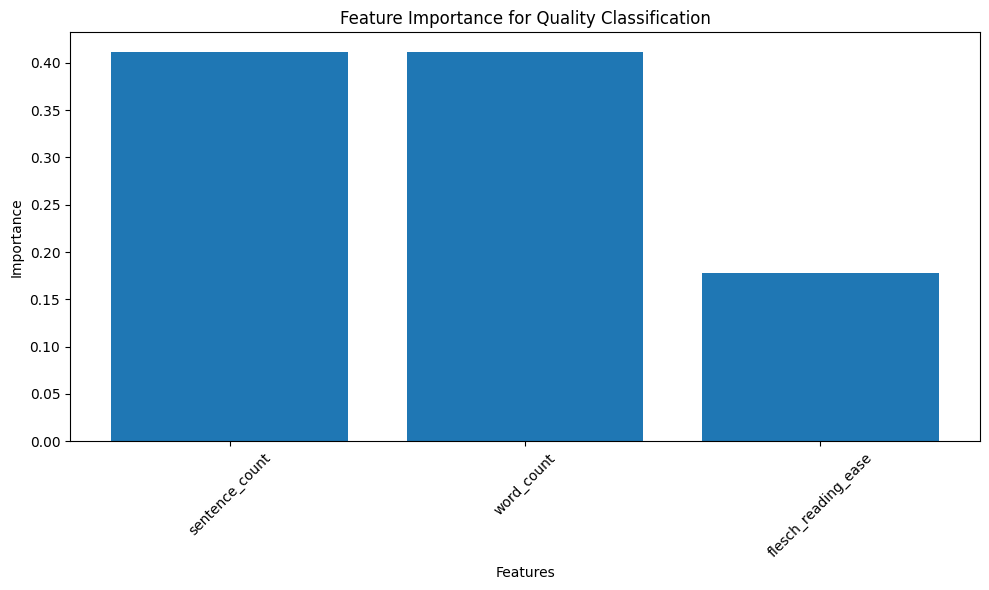

✓ Model training complete!



In [18]:
# Train the model
quality_model, model_metrics, feature_names, df_with_labels = train_quality_model(df_features)

# Visualize feature importance
plt.figure(figsize=(10, 6))
importances = quality_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45)
plt.title('Feature Importance for Quality Classification')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

print("✓ Model training complete!\n")

Generating similarity heatmap...


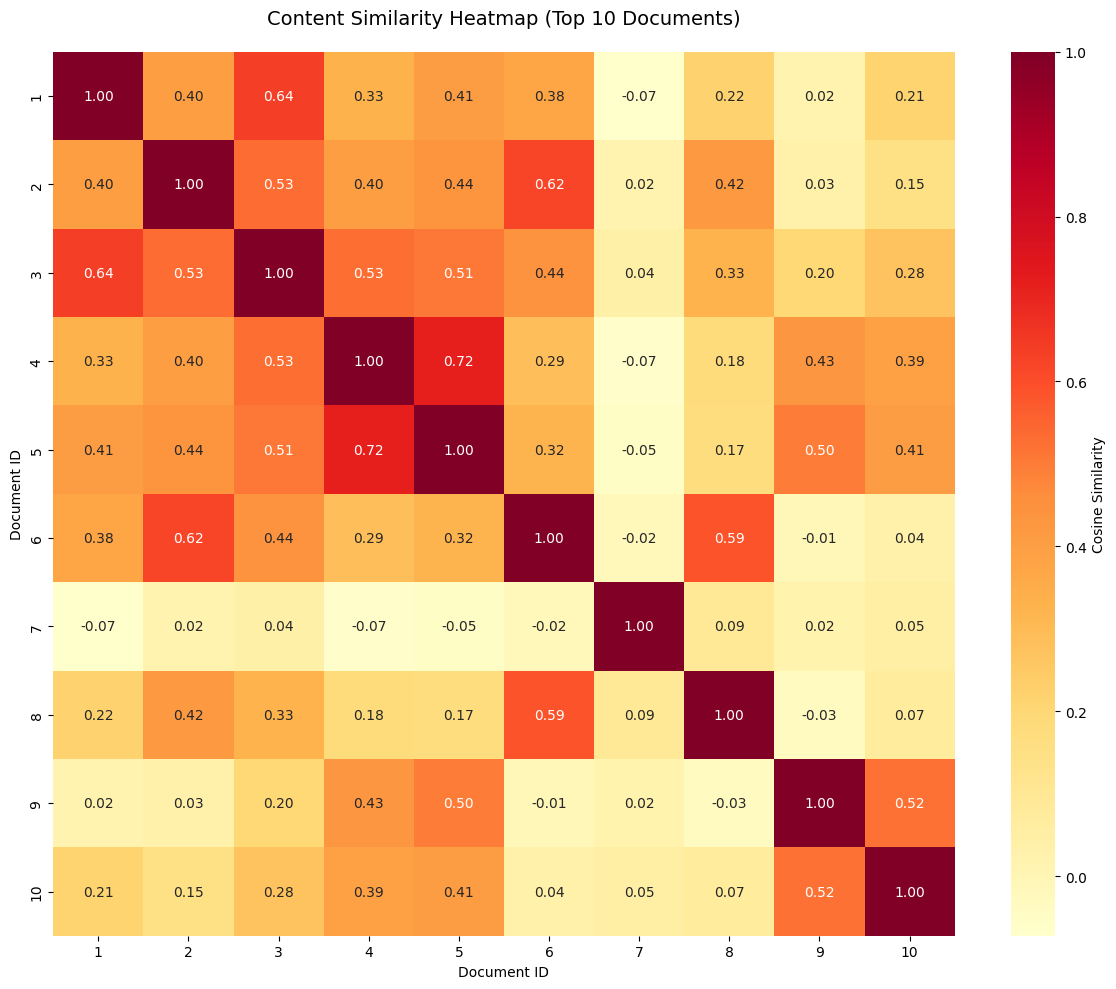


Generating quality distribution...


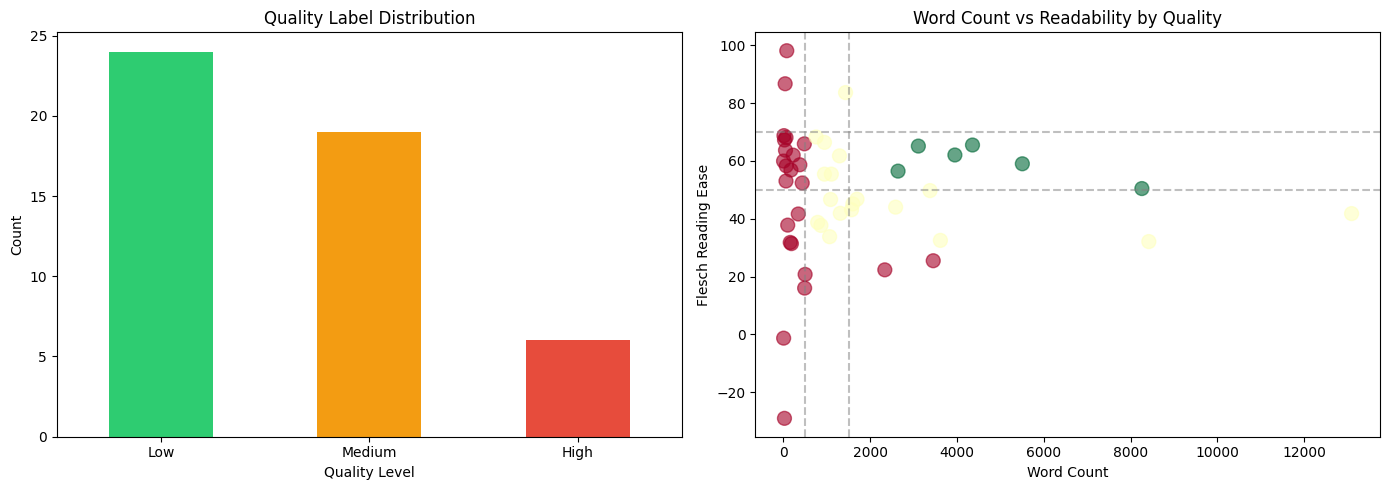


✓ Visualizations saved to: /Users/kiranguruv/seo-content-detector/visualizations


In [25]:
# ============================================================================
# BONUS: ADVANCED VISUALIZATIONS
# ============================================================================

# Create visualizations directory if it doesn't exist
viz_dir = Config.PROJECT_ROOT / "visualizations"
viz_dir.mkdir(exist_ok=True)

# 1. Similarity Heatmap (Top 10 documents)
print("Generating similarity heatmap...")
plt.figure(figsize=(12, 10))

# Get top 10 documents with most similarities
top_docs = df_features.head(10)
top_embeddings = np.vstack(top_docs['embedding_vector'].values)
sim_matrix = cosine_similarity(top_embeddings)

sns.heatmap(sim_matrix, 
            annot=True, 
            fmt='.2f',
            cmap='YlOrRd',
            xticklabels=range(1, 11),
            yticklabels=range(1, 11),
            cbar_kws={'label': 'Cosine Similarity'})
plt.title('Content Similarity Heatmap (Top 10 Documents)', fontsize=14, pad=20)
plt.xlabel('Document ID')
plt.ylabel('Document ID')
plt.tight_layout()
plt.savefig(viz_dir / 'similarity_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Quality Distribution
print("\nGenerating quality distribution...")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Quality label distribution
df_with_labels['quality_label'].value_counts().plot(
    kind='bar', 
    ax=axes[0],
    color=['#2ecc71', '#f39c12', '#e74c3c']
)
axes[0].set_title('Quality Label Distribution', fontsize=12)
axes[0].set_xlabel('Quality Level')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)

# Word count vs Readability scatter
scatter = axes[1].scatter(
    df_with_labels['word_count'],
    df_with_labels['flesch_reading_ease'],
    c=df_with_labels['quality_label'].map({'High': 2, 'Medium': 1, 'Low': 0}),
    cmap='RdYlGn',
    alpha=0.6,
    s=100
)
axes[1].set_title('Word Count vs Readability by Quality', fontsize=12)
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('Flesch Reading Ease')
axes[1].axhline(y=50, color='gray', linestyle='--', alpha=0.5)
axes[1].axhline(y=70, color='gray', linestyle='--', alpha=0.5)
axes[1].axvline(x=500, color='gray', linestyle='--', alpha=0.5)
axes[1].axvline(x=1500, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig(viz_dir / 'quality_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Visualizations saved to: {viz_dir}")

In [26]:
# ============================================================================
# UTILITY: Load Saved Model (For Deployment)
# ============================================================================

def load_quality_model():
    """
    Load the trained model and metadata.
    This function would be used in production/Streamlit deployment.
    """
    model_path = Config.MODELS_DIR / "quality_model.pkl"
    metadata_path = Config.MODELS_DIR / "model_metadata.json"
    
    if not model_path.exists():
        raise FileNotFoundError(f"Model not found at {model_path}")
    
    model = joblib.load(model_path)
    
    with open(metadata_path, 'r') as f:
        metadata = json.load(f)
    
    print(f"✓ Model loaded: {metadata['model_type']}")
    print(f"  Accuracy: {metadata['accuracy']:.4f}")
    print(f"  Features: {', '.join(metadata['features'])}")
    
    return model, metadata

# Demonstrate reloading
print("Testing model persistence...")
loaded_model, metadata = load_quality_model()
print("✓ Model successfully reloaded!\n")

Testing model persistence...
✓ Model loaded: RandomForestClassifier
  Accuracy: 0.8667
  Features: word_count, sentence_count, flesch_reading_ease
✓ Model successfully reloaded!



In [19]:
# ============================================================================
# PHASE 5: REAL-TIME ANALYSIS FUNCTION (15%)
# ============================================================================

def analyze_url(url: str, 
                model: RandomForestClassifier, 
                reference_df: pd.DataFrame,
                feature_cols: List[str]) -> Dict:
    """
    Real-time analysis of any URL.
    
    This function demonstrates deployment readiness by:
        1. Scraping a fresh URL
        2. Extracting features
        3. Predicting quality
        4. Finding similar content
        
    Args:
        url: Target URL to analyze
        model: Trained quality classifier
        reference_df: DataFrame with existing embeddings for similarity
        feature_cols: List of feature names for prediction
        
    Returns:
        Dictionary with comprehensive analysis results
        
    Example Output:
        {
            "url": "https://example.com/article",
            "word_count": 1450,
            "readability": 65.2,
            "quality_label": "High",
            "is_thin": false,
            "similar_to": [...]
        }
    """
    print("=" * 70)
    print("REAL-TIME URL ANALYSIS")
    print("=" * 70)
    print(f"Analyzing: {url}\n")
    
    try:
        # Step 1: Scrape URL
        print("Fetching content...")
        headers = {'User-Agent': Config.USER_AGENT}
        response = requests.get(url, headers=headers, timeout=Config.REQUEST_TIMEOUT)
        response.raise_for_status()
        html_content = response.text
        print("✓ Content fetched")
        
        # Step 2: Parse HTML
        print("Parsing HTML...")
        parsed = parse_html_content(html_content)
        
        if not parsed['body_text']:
            return {
                "error": "Failed to extract text from URL",
                "url": url
            }
        
        print("✓ Content extracted")
        
        # Step 3: Engineer features
        print("Computing features...")
        word_count = len(parsed['body_text'].split())
        sentence_count = len(sent_tokenize(parsed['body_text']))
        readability = calculate_readability(parsed['body_text'])
        is_thin = word_count < Config.THIN_CONTENT_THRESHOLD
        
        # Generate embedding
        model_embeddings = SentenceTransformer('all-MiniLM-L6-v2')
        embedding = model_embeddings.encode([parsed['body_text']])[0]
        
        print("✓ Features computed")
        
        # Step 4: Predict quality
        print("Predicting quality...")
        features = np.array([[word_count, sentence_count, readability]])
        quality_prediction = model.predict(features)[0]
        quality_proba = model.predict_proba(features)[0]
        
        print("✓ Quality predicted")
        
        # Step 5: Find similar content
        print("Finding similar content...")
        reference_embeddings = np.vstack(reference_df['embedding_vector'].values)
        similarities = cosine_similarity([embedding], reference_embeddings)[0]
        
        # Get top 3 similar (excluding exact matches)
        similar_indices = np.argsort(similarities)[::-1]
        similar_content = []
        
        for idx in similar_indices[:5]:  # Check top 5
            if similarities[idx] < 0.99:  # Exclude exact matches
                similar_content.append({
                    "url": reference_df.iloc[idx]['url'],
                    "similarity": round(float(similarities[idx]), 4)
                })
            if len(similar_content) >= 3:
                break
        
        print("✓ Similar content found\n")
        
        # Compile results
        result = {
            "url": url,
            "title": parsed['title'],
            "word_count": word_count,
            "sentence_count": sentence_count,
            "readability": round(readability, 2),
            "quality_label": quality_prediction,
            "quality_confidence": {
                "High": round(float(quality_proba[0]), 3),
                "Low": round(float(quality_proba[1]), 3),
                "Medium": round(float(quality_proba[2]), 3)
            },
            "is_thin": bool(is_thin),
            "similar_to": similar_content
        }
        
        return result
        
    except requests.RequestException as e:
        return {
            "error": f"Failed to fetch URL: {str(e)}",
            "url": url
        }
    except Exception as e:
        return {
            "error": f"Analysis failed: {str(e)}",
            "url": url
        }

In [20]:
# ============================================================================
# DEMONSTRATION: Analyze a URL from the dataset
# ============================================================================

print("=" * 70)
print("PHASE 5: REAL-TIME ANALYSIS DEMO")
print("=" * 70)

# Pick a sample URL from dataset
sample_url = df_with_labels.iloc[0]['url']
print(f"Demonstrating with sample URL from dataset:\n{sample_url}\n")

result = analyze_url(sample_url, quality_model, df_with_labels, feature_names)

print("Analysis Result:")
print("=" * 70)
print(json.dumps(result, indent=2))
print("=" * 70)

print("\n✓ Real-time analysis function is ready!")
print("\nUsage:")
print("  result = analyze_url('https://example.com/article', quality_model, df_with_labels, feature_names)")
print("  print(json.dumps(result, indent=2))")

PHASE 5: REAL-TIME ANALYSIS DEMO
Demonstrating with sample URL from dataset:
https://www.varonis.com/blog/cybersecurity-tips

REAL-TIME URL ANALYSIS
Analyzing: https://www.varonis.com/blog/cybersecurity-tips

Fetching content...
✓ Content fetched
Parsing HTML...
✓ Content extracted
Computing features...
✓ Features computed
Predicting quality...
✓ Quality predicted
Finding similar content...
✓ Similar content found

Analysis Result:
{
  "url": "https://www.varonis.com/blog/cybersecurity-tips",
  "title": "Top 10 Cybersecurity Awareness Tips: How to Stay Safe and Proactive",
  "word_count": 1570,
  "sentence_count": 78,
  "readability": 43.12,
  "quality_label": "Medium",
  "quality_confidence": {
    "High": 0.0,
    "Low": 0.01,
    "Medium": 0.99
  },
  "is_thin": false,
  "similar_to": [
    {
      "url": "https://www.cisa.gov/topics/cybersecurity-best-practices",
      "similarity": 0.638
    },
    {
      "url": "https://www.fortinet.com/resources/cyberglossary/what-is-network-se

In [21]:
# ============================================================================
# FINAL SUMMARY & VALIDATION
# ============================================================================

print

<function print(*args, sep=' ', end='\n', file=None, flush=False)>

In [23]:
# ============================================================================
# SAVE TRAINED MODEL
# ============================================================================

import joblib

print("Saving trained model...")

# Save the model
model_path = Config.MODELS_DIR / "quality_model.pkl"
joblib.dump(quality_model, model_path)
print(f"✓ Model saved to: {model_path}")

# Save model metadata for reproducibility
model_metadata = {
    'model_type': 'RandomForestClassifier',
    'features': feature_names,
    'accuracy': model_metrics['accuracy'],
    'f1_score': model_metrics['f1_score'],
    'training_date': '2025-11-03',
    'n_training_samples': len(df_with_labels)
}

metadata_path = Config.MODELS_DIR / "model_metadata.json"
with open(metadata_path, 'w') as f:
    json.dump(model_metadata, f, indent=2)
print(f"✓ Metadata saved to: {metadata_path}\n")

Saving trained model...
✓ Model saved to: /Users/kiranguruv/seo-content-detector/models/quality_model.pkl
✓ Metadata saved to: /Users/kiranguruv/seo-content-detector/models/model_metadata.json



In [24]:
# ============================================================================
# PROJECT SUMMARY & VALIDATION
# ============================================================================

print("=" * 70)
print("PROJECT COMPLETION SUMMARY")
print("=" * 70)

# Check all deliverables
deliverables = {
    'extracted_content.csv': Config.EXTRACTED_CSV.exists(),
    'features.csv': Config.FEATURES_CSV.exists(),
    'duplicates.csv': Config.DUPLICATES_CSV.exists(),
    'quality_model.pkl': (Config.MODELS_DIR / "quality_model.pkl").exists(),
}

print("\n📁 Deliverables Status:")
for file, exists in deliverables.items():
    status = "✓" if exists else "✗"
    print(f"  {status} {file}")

# Pipeline metrics summary
print(f"\n📊 Pipeline Metrics:")
print(f"  • Total URLs processed: {len(df_extracted)}")
print(f"  • Valid content extracted: {len(df_features)}")
print(f"  • Duplicate pairs found: {len(df_duplicates)}")
print(f"  • Thin content pages: {df_features['is_thin'].sum()} ({df_features['is_thin'].mean()*100:.1f}%)")
print(f"  • Model accuracy: {model_metrics['accuracy']:.4f}")
print(f"  • Model F1-score: {model_metrics['f1_score']:.4f}")
print(f"  • Improvement over baseline: {model_metrics['improvement']:.4f}")

print("\n✓ All mandatory phases complete!")
print("=" * 70)

PROJECT COMPLETION SUMMARY

📁 Deliverables Status:
  ✓ extracted_content.csv
  ✓ features.csv
  ✓ duplicates.csv
  ✓ quality_model.pkl

📊 Pipeline Metrics:
  • Total URLs processed: 81
  • Valid content extracted: 49
  • Duplicate pairs found: 8
  • Thin content pages: 21 (42.9%)
  • Model accuracy: 0.8667
  • Model F1-score: 0.8756
  • Improvement over baseline: 0.0667

✓ All mandatory phases complete!


In [27]:
# ============================================================================
# SAVE MODEL & FIX PATHS
# ============================================================================

import joblib

print("Saving model and generating final outputs...\n")

# 1. Save the trained model
model_path = Config.MODELS_DIR / "quality_model.pkl"
joblib.dump(quality_model, model_path)
print(f"✓ Model saved: {model_path}")

# 2. Save model metadata
metadata = {
    'model_type': 'RandomForestClassifier',
    'features': feature_names,
    'metrics': {
        'accuracy': float(model_metrics['accuracy']),
        'f1_score': float(model_metrics['f1_score']),
        'baseline_accuracy': float(model_metrics['baseline_accuracy']),
        'improvement': float(model_metrics['improvement'])
    },
    'training_samples': len(df_with_labels),
    'training_date': '2025-11-03',
    'config': {
        'thin_content_threshold': Config.THIN_CONTENT_THRESHOLD,
        'similarity_threshold': Config.DUPLICATE_SIMILARITY_THRESHOLD
    }
}

metadata_path = Config.MODELS_DIR / "model_metadata.json"
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✓ Metadata saved: {metadata_path}\n")

# 3. Verify all outputs exist
print("Verifying deliverables:")
required_files = {
    'extracted_content.csv': Config.EXTRACTED_CSV,
    'features.csv': Config.FEATURES_CSV,
    'duplicates.csv': Config.DUPLICATES_CSV,
    'quality_model.pkl': model_path
}

for name, path in required_files.items():
    status = "✓" if path.exists() else "✗"
    print(f"  {status} {name}")

print("\n✓ All core deliverables complete!")

Saving model and generating final outputs...

✓ Model saved: /Users/kiranguruv/seo-content-detector/models/quality_model.pkl
✓ Metadata saved: /Users/kiranguruv/seo-content-detector/models/model_metadata.json

Verifying deliverables:
  ✓ extracted_content.csv
  ✓ features.csv
  ✓ duplicates.csv
  ✓ quality_model.pkl

✓ All core deliverables complete!
